In [1]:
!python -c "import monai; import nibabel; import tqdm" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,#unetr
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR

from monai.data import (
    ThreadDataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
)


import torch

print_config()

MONAI version: 1.2.dev2312
Numpy version: 1.21.5
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 400a6a052f1b2925db6f1323a67a7cf4546403eb
MONAI __file__: /home/user/anaconda3/envs/kevin/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.3.0
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.11.2
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.14.1+cu117
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.3.5
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.h

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpo23daq9e


In [4]:
# num_samples = 4

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# train_transforms = Compose(
#     [
#         LoadImaged(keys=["image", "label"], ensure_channel_first=True),
#         ScaleIntensityRanged(
#             keys=["image"],
#             a_min=-175,
#             a_max=250,
#             b_min=0.0,
#             b_max=1.0,
#             clip=True,
#         ),
#         CropForegroundd(keys=["image", "label"], source_key="image"),
#         Orientationd(keys=["image", "label"], axcodes="RAS"),
#         Spacingd(
#             keys=["image", "label"],
#             pixdim=(1.5, 1.5, 2.0),
#             mode=("bilinear", "nearest"),
#         ),
#         EnsureTyped(keys=["image", "label"], device=device, track_meta=False),
#         RandCropByPosNegLabeld(
#             keys=["image", "label"],
#             label_key="label",
#             spatial_size=(96, 96, 96),
#             pos=1,
#             neg=1,
#             num_samples=num_samples,
#             image_key="image",
#             image_threshold=0,
#         ),
#         RandFlipd(
#             keys=["image", "label"],
#             spatial_axis=[0],
#             prob=0.10,
#         ),
#         RandFlipd(
#             keys=["image", "label"],
#             spatial_axis=[1],
#             prob=0.10,
#         ),
#         RandFlipd(
#             keys=["image", "label"],
#             spatial_axis=[2],
#             prob=0.10,
#         ),
#         RandRotate90d(
#             keys=["image", "label"],
#             prob=0.10,
#             max_k=3,
#         ),
#         RandShiftIntensityd(
#             keys=["image"],
#             offsets=0.10,
#             prob=0.50,
#         ),
#     ]
# )
# val_transforms = Compose(
#     [
#         LoadImaged(keys=["image", "label"], ensure_channel_first=True),
#         ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
#         CropForegroundd(keys=["image", "label"], source_key="image"),
#         Orientationd(keys=["image", "label"], axcodes="RAS"),
#         Spacingd(
#             keys=["image", "label"],
#             pixdim=(1.5, 1.5, 2.0),
#             mode=("bilinear", "nearest"),
#         ),
#         EnsureTyped(keys=["image", "label"], device=device, track_meta=True),
#     ]
# )
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


In [5]:
split_json = "dataset_0.json"
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset1/"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=80,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=1, shuffle=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=20, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# as explained in the "Setup transforms" section above, we want cached training images to not have metadata, and validations to have metadata
# the EnsureTyped transforms allow us to make this distinction
# on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# will be carried out as Tensors, not MetaTensors
set_track_meta(False)

Loading dataset: 100%|████████████████████████████| 4/4 [00:08<00:00,  2.08s/it]


image shape: torch.Size([1, 276, 214, 280]), label shape: torch.Size([1, 276, 214, 280])


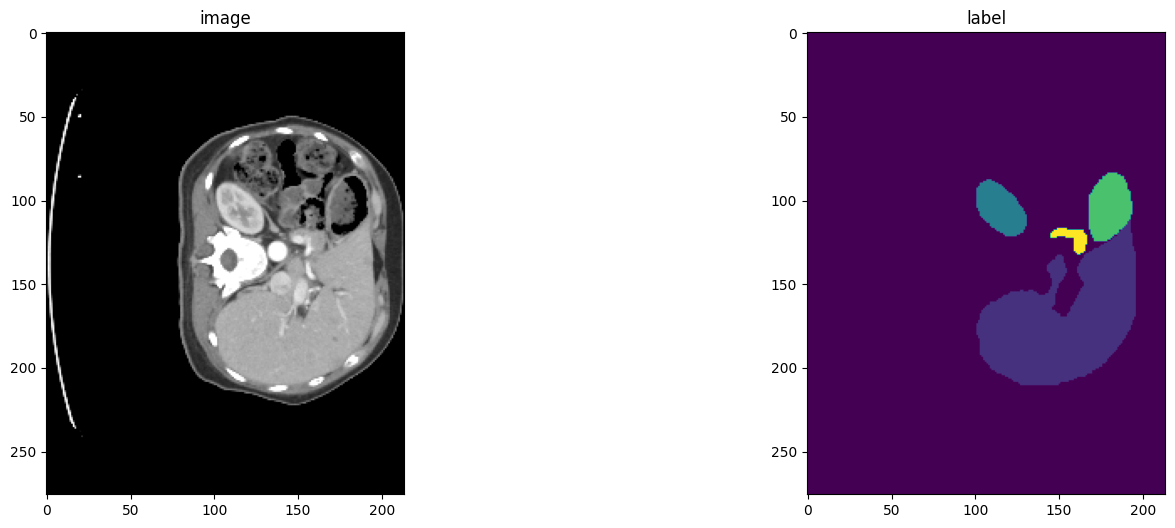

In [6]:
slice_map = {
    "word_0125.nii.gz":177,#cant show label
    "word_0126.nii.gz":224,
    "word_0127.nii.gz":206,
    "word_0128.nii.gz":236,
    "word_0130.nii.gz":159,
    "word_0132.nii.gz":168,#
    "word_0133.nii.gz":226,
    "word_0134.nii.gz":205,#
    "word_0135.nii.gz":230,#
    "word_0136.nii.gz":218,
    "word_0138.nii.gz":223,
    "word_0140.nii.gz":223,#
    "word_0142.nii.gz":200,
    "word_0143.nii.gz":217,
    "word_0144.nii.gz":237,
    "word_0145.nii.gz":226,
    "word_0146.nii.gz":161,
    "word_0147.nii.gz":200,
    "word_0148.nii.gz":242,#
    "word_0150.nii.gz":230,
}
case_num = 1
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

In [7]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=8,
    feature_size=48,
    use_checkpoint=True,
).to(device)

In [8]:
torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

In [10]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val

def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        with torch.cuda.amp.autocast():
            logit_map = model(x)
            loss = loss_function(logit_map, y)
        scaler.scale(loss).backward()
        epoch_loss += loss.item()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        epoch_iterator.set_description(f"Training ({global_step} / {max_iterations} Steps) (loss={loss:2.5f})")
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset1", "swinunetr_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

In [11]:
max_iterations = 25000#30000
eval_num = 500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset1", "swinunetr_best_metric_model.pth")))

Training (79 / 25000 Steps) (loss=1.77464): 100%|█| 80/80 [01:07<00:00,  1.18it/
Training (159 / 25000 Steps) (loss=1.48243): 100%|█| 80/80 [01:03<00:00,  1.27it
Training (239 / 25000 Steps) (loss=1.39337): 100%|█| 80/80 [01:03<00:00,  1.27it
Training (319 / 25000 Steps) (loss=1.35358): 100%|█| 80/80 [01:03<00:00,  1.27it
Training (399 / 25000 Steps) (loss=1.26453): 100%|█| 80/80 [01:03<00:00,  1.27it
Training (479 / 25000 Steps) (loss=1.13756): 100%|█| 80/80 [01:03<00:00,  1.27it
Training (500 / 25000 Steps) (loss=1.14179):  25%|▎| 20/80 [00:16<00:47,  1.26it
Validate (X / X Steps) (dice=X.X):   0%|                  | 0/4 [00:00<?, ?it/s]None of the inputs have requires_grad=True. Gradients will be None

Validate (480 / 10 Steps): 100%|██████████████████| 4/4 [00:14<00:00,  3.51s/it]
Training (500 / 25000 Steps) (loss=1.14179):  26%|▎| 21/80 [00:30<04:59,  5.07s/

Model Was Saved ! Current Best Avg. Dice: 0.2983965277671814 Current Avg. Dice: 0.2983965277671814


Training (559 / 25000 Steps) (loss=1.17671): 100%|█| 80/80 [01:17<00:00,  1.03it
Training (639 / 25000 Steps) (loss=0.94682): 100%|█| 80/80 [01:03<00:00,  1.27it
Training (719 / 25000 Steps) (loss=1.17757): 100%|█| 80/80 [01:03<00:00,  1.27it
Training (799 / 25000 Steps) (loss=0.97772): 100%|█| 80/80 [01:03<00:00,  1.27it
Training (879 / 25000 Steps) (loss=0.91642): 100%|█| 80/80 [01:03<00:00,  1.27it
Training (959 / 25000 Steps) (loss=0.91465): 100%|█| 80/80 [01:03<00:00,  1.27it
Training (1000 / 25000 Steps) (loss=0.95176):  50%|▌| 40/80 [00:32<00:31,  1.27i
Validate (960 / 10 Steps): 100%|██████████████████| 4/4 [00:14<00:00,  3.51s/it]
Training (1000 / 25000 Steps) (loss=0.95176):  51%|▌| 41/80 [00:46<03:18,  5.08s

Model Was Saved ! Current Best Avg. Dice: 0.5756425261497498 Current Avg. Dice: 0.5756425261497498


Training (1039 / 25000 Steps) (loss=0.93875): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (1119 / 25000 Steps) (loss=0.92273): 100%|█| 80/80 [01:03<00:00,  1.26i
Training (1199 / 25000 Steps) (loss=0.83915): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (1279 / 25000 Steps) (loss=0.80660): 100%|█| 80/80 [01:03<00:00,  1.26i
Training (1359 / 25000 Steps) (loss=0.85154): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (1439 / 25000 Steps) (loss=0.80909): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (1500 / 25000 Steps) (loss=0.67532):  75%|▊| 60/80 [00:48<00:15,  1.27i
Validate (1440 / 10 Steps): 100%|█████████████████| 4/4 [00:14<00:00,  3.50s/it]
Training (1500 / 25000 Steps) (loss=0.67532):  76%|▊| 61/80 [01:02<01:36,  5.08s

Model Was Saved ! Current Best Avg. Dice: 0.6634987592697144 Current Avg. Dice: 0.6634987592697144


Training (1519 / 25000 Steps) (loss=0.73970): 100%|█| 80/80 [01:17<00:00,  1.04i
Training (1599 / 25000 Steps) (loss=0.82660): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (1679 / 25000 Steps) (loss=0.73834): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (1759 / 25000 Steps) (loss=0.74634): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (1839 / 25000 Steps) (loss=0.94243): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (1919 / 25000 Steps) (loss=0.75088): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (1999 / 25000 Steps) (loss=0.70815): 100%|█| 80/80 [01:02<00:00,  1.27i
Validate (2000 / 10 Steps): 100%|█████████████████| 4/4 [00:13<00:00,  3.50s/it]
Training (2000 / 25000 Steps) (loss=0.76944):   1%| | 1/80 [00:15<19:54, 15.12s/

Model Was Saved ! Current Best Avg. Dice: 0.7541705965995789 Current Avg. Dice: 0.7541705965995789


Training (2079 / 25000 Steps) (loss=0.76790): 100%|█| 80/80 [01:17<00:00,  1.04i
Training (2159 / 25000 Steps) (loss=0.71218): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (2239 / 25000 Steps) (loss=0.76301): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (2319 / 25000 Steps) (loss=0.82593): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (2399 / 25000 Steps) (loss=0.72606): 100%|█| 80/80 [01:03<00:00,  1.27i
Training (2479 / 25000 Steps) (loss=0.83491): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (2500 / 25000 Steps) (loss=0.90729):  25%|▎| 20/80 [00:16<00:46,  1.28i
Validate (2480 / 10 Steps): 100%|█████████████████| 4/4 [00:13<00:00,  3.49s/it]
Training (2500 / 25000 Steps) (loss=0.90729):  26%|▎| 21/80 [00:30<04:53,  4.97s

Model Was Not Saved ! Current Best Avg. Dice: 0.7541705965995789 Current Avg. Dice: 0.729238748550415


Training (2559 / 25000 Steps) (loss=0.53532): 100%|█| 80/80 [01:16<00:00,  1.04i
Training (2639 / 25000 Steps) (loss=0.57332): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (2719 / 25000 Steps) (loss=0.78889): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (2799 / 25000 Steps) (loss=0.75177): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (2879 / 25000 Steps) (loss=0.81535): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (2959 / 25000 Steps) (loss=0.67372): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (3000 / 25000 Steps) (loss=0.63332):  50%|▌| 40/80 [00:32<00:31,  1.27i
Validate (2960 / 10 Steps): 100%|█████████████████| 4/4 [00:13<00:00,  3.49s/it]
Training (3000 / 25000 Steps) (loss=0.63332):  51%|▌| 41/80 [00:46<03:17,  5.06s

Model Was Saved ! Current Best Avg. Dice: 0.8025438189506531 Current Avg. Dice: 0.8025438189506531


Training (3039 / 25000 Steps) (loss=0.73753): 100%|█| 80/80 [01:17<00:00,  1.04i
Training (3119 / 25000 Steps) (loss=0.81306): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (3199 / 25000 Steps) (loss=0.75631): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (3279 / 25000 Steps) (loss=0.50153): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (3359 / 25000 Steps) (loss=0.65926): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (3439 / 25000 Steps) (loss=0.49805): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (3500 / 25000 Steps) (loss=0.60404):  75%|▊| 60/80 [00:47<00:15,  1.27i
Validate (3440 / 10 Steps): 100%|█████████████████| 4/4 [00:13<00:00,  3.48s/it]
Training (3500 / 25000 Steps) (loss=0.60404):  76%|▊| 61/80 [01:02<01:36,  5.05s

Model Was Saved ! Current Best Avg. Dice: 0.8331619501113892 Current Avg. Dice: 0.8331619501113892


Training (3519 / 25000 Steps) (loss=0.73690): 100%|█| 80/80 [01:16<00:00,  1.04i
Training (3599 / 25000 Steps) (loss=0.82924): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (3679 / 25000 Steps) (loss=0.71292): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (3759 / 25000 Steps) (loss=0.58870): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (3839 / 25000 Steps) (loss=0.93679): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (3919 / 25000 Steps) (loss=0.62476): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (3999 / 25000 Steps) (loss=0.69088): 100%|█| 80/80 [01:02<00:00,  1.27i
Validate (4000 / 10 Steps): 100%|█████████████████| 4/4 [00:13<00:00,  3.48s/it]
Training (4000 / 25000 Steps) (loss=0.58379):   1%| | 1/80 [00:14<19:28, 14.79s/

Model Was Not Saved ! Current Best Avg. Dice: 0.8331619501113892 Current Avg. Dice: 0.8281248807907104


Training (4079 / 25000 Steps) (loss=1.10670): 100%|█| 80/80 [01:16<00:00,  1.04i
Training (4159 / 25000 Steps) (loss=0.93315): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (4239 / 25000 Steps) (loss=0.67368): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (4319 / 25000 Steps) (loss=0.49806): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (4399 / 25000 Steps) (loss=0.65309): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (4479 / 25000 Steps) (loss=0.57309): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (4500 / 25000 Steps) (loss=0.79921):  25%|▎| 20/80 [00:16<00:47,  1.27i
Validate (4480 / 10 Steps): 100%|█████████████████| 4/4 [00:13<00:00,  3.49s/it]
Training (4500 / 25000 Steps) (loss=0.79921):  26%|▎| 21/80 [00:30<04:58,  5.06s

Model Was Saved ! Current Best Avg. Dice: 0.8439970016479492 Current Avg. Dice: 0.8439970016479492


Training (4559 / 25000 Steps) (loss=0.78014): 100%|█| 80/80 [01:17<00:00,  1.04i
Training (4639 / 25000 Steps) (loss=0.67265): 100%|█| 80/80 [01:03<00:00,  1.27i
Training (4719 / 25000 Steps) (loss=0.62721): 100%|█| 80/80 [01:03<00:00,  1.26i
Training (4799 / 25000 Steps) (loss=0.64445): 100%|█| 80/80 [01:03<00:00,  1.26i
Training (4879 / 25000 Steps) (loss=0.65434): 100%|█| 80/80 [01:03<00:00,  1.26i
Training (4959 / 25000 Steps) (loss=0.75277): 100%|█| 80/80 [01:03<00:00,  1.27i
Training (5000 / 25000 Steps) (loss=0.78139):  50%|▌| 40/80 [00:32<00:31,  1.27i
Validate (4960 / 10 Steps): 100%|█████████████████| 4/4 [00:14<00:00,  3.51s/it]
Training (5000 / 25000 Steps) (loss=0.78139):  51%|▌| 41/80 [00:46<03:18,  5.09s

Model Was Saved ! Current Best Avg. Dice: 0.8444889783859253 Current Avg. Dice: 0.8444889783859253


Training (5039 / 25000 Steps) (loss=0.64009): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (5119 / 25000 Steps) (loss=0.55171): 100%|█| 80/80 [01:03<00:00,  1.27i
Training (5199 / 25000 Steps) (loss=0.65525): 100%|█| 80/80 [01:03<00:00,  1.27i
Training (5279 / 25000 Steps) (loss=0.82849): 100%|█| 80/80 [01:03<00:00,  1.27i
Training (5359 / 25000 Steps) (loss=0.78060): 100%|█| 80/80 [01:03<00:00,  1.27i
Training (5439 / 25000 Steps) (loss=0.83472): 100%|█| 80/80 [01:03<00:00,  1.26i
Training (5500 / 25000 Steps) (loss=0.59851):  75%|▊| 60/80 [00:48<00:15,  1.27i
Validate (5440 / 10 Steps): 100%|█████████████████| 4/4 [00:14<00:00,  3.51s/it]
Training (5500 / 25000 Steps) (loss=0.59851):  76%|▊| 61/80 [01:02<01:34,  5.00s

Model Was Not Saved ! Current Best Avg. Dice: 0.8444889783859253 Current Avg. Dice: 0.834658145904541


Training (5519 / 25000 Steps) (loss=0.57658): 100%|█| 80/80 [01:17<00:00,  1.04i
Training (5599 / 25000 Steps) (loss=0.63927): 100%|█| 80/80 [01:03<00:00,  1.27i
Training (5679 / 25000 Steps) (loss=0.51975): 100%|█| 80/80 [01:03<00:00,  1.27i
Training (5759 / 25000 Steps) (loss=0.56451): 100%|█| 80/80 [01:03<00:00,  1.27i
Training (5839 / 25000 Steps) (loss=0.86428): 100%|█| 80/80 [01:03<00:00,  1.27i
Training (5919 / 25000 Steps) (loss=0.78571): 100%|█| 80/80 [01:03<00:00,  1.27i
Training (5999 / 25000 Steps) (loss=0.64543): 100%|█| 80/80 [01:03<00:00,  1.27i
Validate (6000 / 10 Steps): 100%|█████████████████| 4/4 [00:14<00:00,  3.53s/it]
Training (6000 / 25000 Steps) (loss=0.55132):   1%| | 1/80 [00:14<19:43, 14.98s/

Model Was Not Saved ! Current Best Avg. Dice: 0.8444889783859253 Current Avg. Dice: 0.8410745859146118


Training (6079 / 25000 Steps) (loss=0.60287): 100%|█| 80/80 [01:17<00:00,  1.04i
Training (6159 / 25000 Steps) (loss=0.69959): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (6239 / 25000 Steps) (loss=0.64725): 100%|█| 80/80 [01:03<00:00,  1.27i
Training (6319 / 25000 Steps) (loss=0.81060): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (6399 / 25000 Steps) (loss=0.55144): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (6479 / 25000 Steps) (loss=0.72428): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (6500 / 25000 Steps) (loss=0.54465):  25%|▎| 20/80 [00:16<00:46,  1.28i
Validate (6480 / 10 Steps): 100%|█████████████████| 4/4 [00:14<00:00,  3.52s/it]
Training (6500 / 25000 Steps) (loss=0.54465):  26%|▎| 21/80 [00:30<05:00,  5.10s

Model Was Saved ! Current Best Avg. Dice: 0.8464370369911194 Current Avg. Dice: 0.8464370369911194


Training (6559 / 25000 Steps) (loss=0.68427): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (6639 / 25000 Steps) (loss=0.43400): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (6719 / 25000 Steps) (loss=0.52174): 100%|█| 80/80 [01:03<00:00,  1.27i
Training (6799 / 25000 Steps) (loss=0.70652): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (6879 / 25000 Steps) (loss=0.68340): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (6959 / 25000 Steps) (loss=0.64965): 100%|█| 80/80 [01:03<00:00,  1.27i
Training (7000 / 25000 Steps) (loss=0.69487):  50%|▌| 40/80 [00:32<00:31,  1.27i
Validate (6960 / 10 Steps): 100%|█████████████████| 4/4 [00:13<00:00,  3.48s/it]
Training (7000 / 25000 Steps) (loss=0.69487):  51%|▌| 41/80 [00:46<03:16,  5.05s

Model Was Saved ! Current Best Avg. Dice: 0.8482688665390015 Current Avg. Dice: 0.8482688665390015


Training (7039 / 25000 Steps) (loss=0.29272): 100%|█| 80/80 [01:16<00:00,  1.04i
Training (7119 / 25000 Steps) (loss=0.45094): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (7199 / 25000 Steps) (loss=0.52955): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (7279 / 25000 Steps) (loss=0.65966): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (7359 / 25000 Steps) (loss=0.61231): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (7439 / 25000 Steps) (loss=0.54512): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (7500 / 25000 Steps) (loss=0.70171):  75%|▊| 60/80 [00:47<00:15,  1.28i
Validate (7440 / 10 Steps): 100%|█████████████████| 4/4 [00:13<00:00,  3.49s/it]
Training (7500 / 25000 Steps) (loss=0.70171):  76%|▊| 61/80 [01:02<01:36,  5.06s

Model Was Saved ! Current Best Avg. Dice: 0.8500598669052124 Current Avg. Dice: 0.8500598669052124


Training (7519 / 25000 Steps) (loss=0.75159): 100%|█| 80/80 [01:16<00:00,  1.04i
Training (7599 / 25000 Steps) (loss=0.68400): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (7679 / 25000 Steps) (loss=0.73063): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (7759 / 25000 Steps) (loss=0.71932): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (7839 / 25000 Steps) (loss=0.54607): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (7919 / 25000 Steps) (loss=0.71883): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (7999 / 25000 Steps) (loss=0.65775): 100%|█| 80/80 [01:02<00:00,  1.28i
Validate (8000 / 10 Steps): 100%|█████████████████| 4/4 [00:13<00:00,  3.49s/it]
Training (8000 / 25000 Steps) (loss=0.63648):   1%| | 1/80 [00:15<19:51, 15.08s/

Model Was Saved ! Current Best Avg. Dice: 0.8567337989807129 Current Avg. Dice: 0.8567337989807129


Training (8079 / 25000 Steps) (loss=0.53633): 100%|█| 80/80 [01:16<00:00,  1.04i
Training (8159 / 25000 Steps) (loss=0.69445): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (8239 / 25000 Steps) (loss=0.67523): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (8319 / 25000 Steps) (loss=0.31947): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (8399 / 25000 Steps) (loss=0.49970): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (8479 / 25000 Steps) (loss=0.71036): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (8500 / 25000 Steps) (loss=0.72600):  25%|▎| 20/80 [00:16<00:47,  1.26i
Validate (8480 / 10 Steps): 100%|█████████████████| 4/4 [00:14<00:00,  3.54s/it]
Training (8500 / 25000 Steps) (loss=0.72600):  26%|▎| 21/80 [00:31<05:02,  5.13s

Model Was Saved ! Current Best Avg. Dice: 0.8628587126731873 Current Avg. Dice: 0.8628587126731873


Training (8559 / 25000 Steps) (loss=0.42887): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (8639 / 25000 Steps) (loss=0.69731): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (8719 / 25000 Steps) (loss=0.68435): 100%|█| 80/80 [01:03<00:00,  1.27i
Training (8799 / 25000 Steps) (loss=0.63960): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (8879 / 25000 Steps) (loss=0.56095): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (8959 / 25000 Steps) (loss=0.56361): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (9000 / 25000 Steps) (loss=0.54669):  50%|▌| 40/80 [00:32<00:31,  1.27i
Validate (8960 / 10 Steps): 100%|█████████████████| 4/4 [00:14<00:00,  3.53s/it]
Training (9000 / 25000 Steps) (loss=0.54669):  51%|▌| 41/80 [00:46<03:15,  5.02s

Model Was Not Saved ! Current Best Avg. Dice: 0.8628587126731873 Current Avg. Dice: 0.8473134636878967


Training (9039 / 25000 Steps) (loss=0.67135): 100%|█| 80/80 [01:17<00:00,  1.04i
Training (9119 / 25000 Steps) (loss=0.49516): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (9199 / 25000 Steps) (loss=0.54464): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (9279 / 25000 Steps) (loss=0.69063): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (9359 / 25000 Steps) (loss=0.58290): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (9439 / 25000 Steps) (loss=0.79854): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (9500 / 25000 Steps) (loss=0.56314):  75%|▊| 60/80 [00:48<00:15,  1.28i
Validate (9440 / 10 Steps): 100%|█████████████████| 4/4 [00:14<00:00,  3.53s/it]
Training (9500 / 25000 Steps) (loss=0.56314):  76%|▊| 61/80 [01:02<01:36,  5.10s

Model Was Saved ! Current Best Avg. Dice: 0.8683251142501831 Current Avg. Dice: 0.8683251142501831


Training (9519 / 25000 Steps) (loss=0.79141): 100%|█| 80/80 [01:17<00:00,  1.03i
Training (9599 / 25000 Steps) (loss=0.45250): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (9679 / 25000 Steps) (loss=0.66542): 100%|█| 80/80 [01:02<00:00,  1.27i
Training (9759 / 25000 Steps) (loss=0.64669): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (9839 / 25000 Steps) (loss=0.68374): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (9919 / 25000 Steps) (loss=0.85664): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (9999 / 25000 Steps) (loss=0.46251): 100%|█| 80/80 [01:02<00:00,  1.28i
Validate (10000 / 10 Steps): 100%|████████████████| 4/4 [00:13<00:00,  3.49s/it]
Training (10000 / 25000 Steps) (loss=0.77210):   1%| | 1/80 [00:14<19:28, 14.79s

Model Was Not Saved ! Current Best Avg. Dice: 0.8683251142501831 Current Avg. Dice: 0.8649290800094604


Training (10079 / 25000 Steps) (loss=0.53356): 100%|█| 80/80 [01:16<00:00,  1.04
Training (10159 / 25000 Steps) (loss=0.39262): 100%|█| 80/80 [01:02<00:00,  1.28
Training (10239 / 25000 Steps) (loss=0.50183): 100%|█| 80/80 [01:02<00:00,  1.28
Training (10319 / 25000 Steps) (loss=0.60338): 100%|█| 80/80 [01:02<00:00,  1.28
Training (10399 / 25000 Steps) (loss=0.52291): 100%|█| 80/80 [01:02<00:00,  1.28
Training (10479 / 25000 Steps) (loss=0.69522): 100%|█| 80/80 [01:02<00:00,  1.28
Training (10500 / 25000 Steps) (loss=0.45256):  25%|▎| 20/80 [00:16<00:46,  1.28
Validate (10480 / 10 Steps): 100%|████████████████| 4/4 [00:13<00:00,  3.49s/it]
Training (10500 / 25000 Steps) (loss=0.45256):  26%|▎| 21/80 [00:30<04:53,  4.98

Model Was Not Saved ! Current Best Avg. Dice: 0.8683251142501831 Current Avg. Dice: 0.8657634854316711


Training (10559 / 25000 Steps) (loss=0.72433): 100%|█| 80/80 [01:16<00:00,  1.04
Training (10639 / 25000 Steps) (loss=0.52865): 100%|█| 80/80 [01:02<00:00,  1.28
Training (10719 / 25000 Steps) (loss=0.50746): 100%|█| 80/80 [01:03<00:00,  1.27
Training (10799 / 25000 Steps) (loss=0.59389): 100%|█| 80/80 [01:03<00:00,  1.27
Training (10879 / 25000 Steps) (loss=0.65274): 100%|█| 80/80 [01:03<00:00,  1.27
Training (10959 / 25000 Steps) (loss=0.39348): 100%|█| 80/80 [01:03<00:00,  1.27
Training (11000 / 25000 Steps) (loss=0.63948):  50%|▌| 40/80 [00:32<00:31,  1.27
Validate (10960 / 10 Steps): 100%|████████████████| 4/4 [00:14<00:00,  3.53s/it]
Training (11000 / 25000 Steps) (loss=0.63948):  51%|▌| 41/80 [00:46<03:16,  5.03

Model Was Not Saved ! Current Best Avg. Dice: 0.8683251142501831 Current Avg. Dice: 0.8646126985549927


Training (11039 / 25000 Steps) (loss=0.56339): 100%|█| 80/80 [01:17<00:00,  1.04
Training (11119 / 25000 Steps) (loss=0.58072): 100%|█| 80/80 [01:03<00:00,  1.27
Training (11199 / 25000 Steps) (loss=0.47648): 100%|█| 80/80 [01:03<00:00,  1.27
Training (11279 / 25000 Steps) (loss=0.60396): 100%|█| 80/80 [01:03<00:00,  1.27
Training (11359 / 25000 Steps) (loss=0.64497): 100%|█| 80/80 [01:02<00:00,  1.27
Training (11439 / 25000 Steps) (loss=0.57362): 100%|█| 80/80 [01:03<00:00,  1.27
Training (11500 / 25000 Steps) (loss=0.54495):  75%|▊| 60/80 [00:48<00:15,  1.27
Validate (11440 / 10 Steps): 100%|████████████████| 4/4 [00:14<00:00,  3.54s/it]
Training (11500 / 25000 Steps) (loss=0.54495):  76%|▊| 61/80 [01:02<01:37,  5.12

Model Was Saved ! Current Best Avg. Dice: 0.874031662940979 Current Avg. Dice: 0.874031662940979


Training (11519 / 25000 Steps) (loss=0.47157): 100%|█| 80/80 [01:17<00:00,  1.03
Training (11599 / 25000 Steps) (loss=0.84057): 100%|█| 80/80 [01:02<00:00,  1.27
Training (11679 / 25000 Steps) (loss=0.39866): 100%|█| 80/80 [01:03<00:00,  1.27
Training (11759 / 25000 Steps) (loss=0.81788): 100%|█| 80/80 [01:03<00:00,  1.27
Training (11839 / 25000 Steps) (loss=0.52068): 100%|█| 80/80 [01:03<00:00,  1.27
Training (11919 / 25000 Steps) (loss=0.68658): 100%|█| 80/80 [01:02<00:00,  1.28
Training (11999 / 25000 Steps) (loss=0.52285): 100%|█| 80/80 [01:02<00:00,  1.28
Validate (12000 / 10 Steps): 100%|████████████████| 4/4 [00:13<00:00,  3.50s/it]
Training (12000 / 25000 Steps) (loss=0.63200):   1%| | 1/80 [00:14<19:34, 14.86s

Model Was Not Saved ! Current Best Avg. Dice: 0.874031662940979 Current Avg. Dice: 0.8614531755447388


Training (12079 / 25000 Steps) (loss=0.57944): 100%|█| 80/80 [01:16<00:00,  1.04
Training (12159 / 25000 Steps) (loss=0.71226): 100%|█| 80/80 [01:02<00:00,  1.28
Training (12239 / 25000 Steps) (loss=0.43359): 100%|█| 80/80 [01:02<00:00,  1.28
Training (12319 / 25000 Steps) (loss=0.60077): 100%|█| 80/80 [01:02<00:00,  1.28
Training (12399 / 25000 Steps) (loss=0.46516): 100%|█| 80/80 [01:02<00:00,  1.28
Training (12479 / 25000 Steps) (loss=0.79622): 100%|█| 80/80 [01:02<00:00,  1.28
Training (12500 / 25000 Steps) (loss=0.55792):  25%|▎| 20/80 [00:16<00:47,  1.28
Validate (12480 / 10 Steps): 100%|████████████████| 4/4 [00:13<00:00,  3.49s/it]
Training (12500 / 25000 Steps) (loss=0.55792):  26%|▎| 21/80 [00:30<04:53,  4.98

Model Was Not Saved ! Current Best Avg. Dice: 0.874031662940979 Current Avg. Dice: 0.8621524572372437


Training (12559 / 25000 Steps) (loss=0.42917): 100%|█| 80/80 [01:16<00:00,  1.04
Training (12639 / 25000 Steps) (loss=0.75432): 100%|█| 80/80 [01:02<00:00,  1.28
Training (12719 / 25000 Steps) (loss=0.49369): 100%|█| 80/80 [01:02<00:00,  1.28
Training (12799 / 25000 Steps) (loss=0.55311): 100%|█| 80/80 [01:02<00:00,  1.28
Training (12879 / 25000 Steps) (loss=0.48464): 100%|█| 80/80 [01:02<00:00,  1.28
Training (12959 / 25000 Steps) (loss=0.42168): 100%|█| 80/80 [01:02<00:00,  1.28
Training (13000 / 25000 Steps) (loss=0.40396):  50%|▌| 40/80 [00:32<00:31,  1.28
Validate (12960 / 10 Steps): 100%|████████████████| 4/4 [00:13<00:00,  3.49s/it]
Training (13000 / 25000 Steps) (loss=0.40396):  51%|▌| 41/80 [00:46<03:14,  4.98

Model Was Not Saved ! Current Best Avg. Dice: 0.874031662940979 Current Avg. Dice: 0.8672059774398804


Training (13039 / 25000 Steps) (loss=0.51740): 100%|█| 80/80 [01:16<00:00,  1.04
Training (13119 / 25000 Steps) (loss=0.59972): 100%|█| 80/80 [01:02<00:00,  1.28
Training (13199 / 25000 Steps) (loss=0.90896): 100%|█| 80/80 [01:02<00:00,  1.28
Training (13279 / 25000 Steps) (loss=0.68249): 100%|█| 80/80 [01:02<00:00,  1.27
Training (13359 / 25000 Steps) (loss=0.70202): 100%|█| 80/80 [01:02<00:00,  1.28
Training (13439 / 25000 Steps) (loss=0.71761): 100%|█| 80/80 [01:02<00:00,  1.28
Training (13500 / 25000 Steps) (loss=0.58850):  75%|▊| 60/80 [00:47<00:15,  1.28
Validate (13440 / 10 Steps): 100%|████████████████| 4/4 [00:13<00:00,  3.48s/it]
Training (13500 / 25000 Steps) (loss=0.58850):  76%|▊| 61/80 [01:02<01:35,  5.04

Model Was Saved ! Current Best Avg. Dice: 0.8761154413223267 Current Avg. Dice: 0.8761154413223267


Training (13519 / 25000 Steps) (loss=0.62108): 100%|█| 80/80 [01:16<00:00,  1.04
Training (13599 / 25000 Steps) (loss=0.57679): 100%|█| 80/80 [01:02<00:00,  1.28
Training (13679 / 25000 Steps) (loss=0.56195): 100%|█| 80/80 [01:02<00:00,  1.28
Training (13759 / 25000 Steps) (loss=0.56618): 100%|█| 80/80 [01:02<00:00,  1.27
Training (13839 / 25000 Steps) (loss=0.46276): 100%|█| 80/80 [01:02<00:00,  1.28
Training (13919 / 25000 Steps) (loss=0.63950): 100%|█| 80/80 [01:02<00:00,  1.28
Training (13999 / 25000 Steps) (loss=0.47216): 100%|█| 80/80 [01:02<00:00,  1.28
Validate (14000 / 10 Steps): 100%|████████████████| 4/4 [00:13<00:00,  3.49s/it]
Training (14000 / 25000 Steps) (loss=0.64162):   1%| | 1/80 [00:14<19:31, 14.82s

Model Was Not Saved ! Current Best Avg. Dice: 0.8761154413223267 Current Avg. Dice: 0.8731329441070557


Training (14079 / 25000 Steps) (loss=0.56701): 100%|█| 80/80 [01:16<00:00,  1.04
Training (14159 / 25000 Steps) (loss=0.73924): 100%|█| 80/80 [01:02<00:00,  1.28
Training (14239 / 25000 Steps) (loss=0.60802): 100%|█| 80/80 [01:02<00:00,  1.27
Training (14319 / 25000 Steps) (loss=0.49526): 100%|█| 80/80 [01:02<00:00,  1.28
Training (14399 / 25000 Steps) (loss=0.66612): 100%|█| 80/80 [01:02<00:00,  1.28
Training (14479 / 25000 Steps) (loss=0.67871): 100%|█| 80/80 [01:02<00:00,  1.28
Training (14500 / 25000 Steps) (loss=0.64820):  25%|▎| 20/80 [00:16<00:46,  1.28
Validate (14480 / 10 Steps): 100%|████████████████| 4/4 [00:13<00:00,  3.49s/it]
Training (14500 / 25000 Steps) (loss=0.64820):  26%|▎| 21/80 [00:30<04:53,  4.97

Model Was Not Saved ! Current Best Avg. Dice: 0.8761154413223267 Current Avg. Dice: 0.8531883955001831


Training (14559 / 25000 Steps) (loss=0.68701): 100%|█| 80/80 [01:16<00:00,  1.04
Training (14639 / 25000 Steps) (loss=0.68153): 100%|█| 80/80 [01:02<00:00,  1.28
Training (14719 / 25000 Steps) (loss=0.70708): 100%|█| 80/80 [01:02<00:00,  1.28
Training (14799 / 25000 Steps) (loss=0.71501): 100%|█| 80/80 [01:02<00:00,  1.28
Training (14879 / 25000 Steps) (loss=0.41282): 100%|█| 80/80 [01:03<00:00,  1.27
Training (14959 / 25000 Steps) (loss=0.34865): 100%|█| 80/80 [01:03<00:00,  1.27
Training (15000 / 25000 Steps) (loss=0.77656):  50%|▌| 40/80 [00:32<00:31,  1.27
Validate (14960 / 10 Steps): 100%|████████████████| 4/4 [00:14<00:00,  3.53s/it]
Training (15000 / 25000 Steps) (loss=0.77656):  51%|▌| 41/80 [00:46<03:18,  5.10

Model Was Saved ! Current Best Avg. Dice: 0.8773021697998047 Current Avg. Dice: 0.8773021697998047


Training (15039 / 25000 Steps) (loss=0.66165): 100%|█| 80/80 [01:17<00:00,  1.03
Training (15119 / 25000 Steps) (loss=0.52459): 100%|█| 80/80 [01:02<00:00,  1.27
Training (15199 / 25000 Steps) (loss=0.50811): 100%|█| 80/80 [01:02<00:00,  1.27
Training (15279 / 25000 Steps) (loss=0.57205): 100%|█| 80/80 [01:02<00:00,  1.27
Training (15359 / 25000 Steps) (loss=0.78507): 100%|█| 80/80 [01:02<00:00,  1.27
Training (15439 / 25000 Steps) (loss=0.56345): 100%|█| 80/80 [01:03<00:00,  1.27
Training (15500 / 25000 Steps) (loss=0.67822):  75%|▊| 60/80 [00:48<00:15,  1.27
Validate (15440 / 10 Steps): 100%|████████████████| 4/4 [00:14<00:00,  3.52s/it]
Training (15500 / 25000 Steps) (loss=0.67822):  76%|▊| 61/80 [01:02<01:35,  5.02

Model Was Not Saved ! Current Best Avg. Dice: 0.8773021697998047 Current Avg. Dice: 0.8747447729110718


Training (15519 / 25000 Steps) (loss=0.65231): 100%|█| 80/80 [01:17<00:00,  1.04
Training (15599 / 25000 Steps) (loss=0.63816): 100%|█| 80/80 [01:02<00:00,  1.27
Training (15679 / 25000 Steps) (loss=0.84462): 100%|█| 80/80 [01:02<00:00,  1.27
Training (15759 / 25000 Steps) (loss=0.62197): 100%|█| 80/80 [01:02<00:00,  1.27
Training (15839 / 25000 Steps) (loss=0.52461): 100%|█| 80/80 [01:02<00:00,  1.27
Training (15919 / 25000 Steps) (loss=0.40998): 100%|█| 80/80 [01:02<00:00,  1.27
Training (15999 / 25000 Steps) (loss=0.80965): 100%|█| 80/80 [01:03<00:00,  1.27
Validate (16000 / 10 Steps): 100%|████████████████| 4/4 [00:13<00:00,  3.48s/it]
Training (16000 / 25000 Steps) (loss=0.53875):   1%| | 1/80 [00:14<19:30, 14.82s

Model Was Not Saved ! Current Best Avg. Dice: 0.8773021697998047 Current Avg. Dice: 0.8723482489585876


Training (16079 / 25000 Steps) (loss=0.39126): 100%|█| 80/80 [01:16<00:00,  1.04
Training (16159 / 25000 Steps) (loss=0.52539): 100%|█| 80/80 [01:02<00:00,  1.28
Training (16239 / 25000 Steps) (loss=0.61663): 100%|█| 80/80 [01:02<00:00,  1.28
Training (16319 / 25000 Steps) (loss=0.55993): 100%|█| 80/80 [01:02<00:00,  1.28
Training (16399 / 25000 Steps) (loss=0.52791): 100%|█| 80/80 [01:02<00:00,  1.28
Training (16479 / 25000 Steps) (loss=0.59540): 100%|█| 80/80 [01:02<00:00,  1.28
Training (16500 / 25000 Steps) (loss=0.70401):  25%|▎| 20/80 [00:16<00:46,  1.28
Validate (16480 / 10 Steps): 100%|████████████████| 4/4 [00:13<00:00,  3.49s/it]
Training (16500 / 25000 Steps) (loss=0.70401):  26%|▎| 21/80 [00:30<04:53,  4.97

Model Was Not Saved ! Current Best Avg. Dice: 0.8773021697998047 Current Avg. Dice: 0.8676564693450928


Training (16559 / 25000 Steps) (loss=0.44528): 100%|█| 80/80 [01:16<00:00,  1.04
Training (16639 / 25000 Steps) (loss=0.49978): 100%|█| 80/80 [01:02<00:00,  1.28
Training (16719 / 25000 Steps) (loss=0.46387): 100%|█| 80/80 [01:02<00:00,  1.28
Training (16799 / 25000 Steps) (loss=0.79352): 100%|█| 80/80 [01:02<00:00,  1.28
Training (16879 / 25000 Steps) (loss=0.65159): 100%|█| 80/80 [01:02<00:00,  1.28
Training (16959 / 25000 Steps) (loss=0.50437): 100%|█| 80/80 [01:02<00:00,  1.28
Training (17000 / 25000 Steps) (loss=0.63744):  50%|▌| 40/80 [00:32<00:31,  1.28
Validate (16960 / 10 Steps): 100%|████████████████| 4/4 [00:13<00:00,  3.48s/it]
Training (17000 / 25000 Steps) (loss=0.63744):  51%|▌| 41/80 [00:46<03:13,  4.96

Model Was Not Saved ! Current Best Avg. Dice: 0.8773021697998047 Current Avg. Dice: 0.876055896282196


Training (17039 / 25000 Steps) (loss=0.52438): 100%|█| 80/80 [01:16<00:00,  1.04
Training (17119 / 25000 Steps) (loss=0.61697): 100%|█| 80/80 [01:02<00:00,  1.28
Training (17199 / 25000 Steps) (loss=0.52514): 100%|█| 80/80 [01:02<00:00,  1.28
Training (17279 / 25000 Steps) (loss=0.48893): 100%|█| 80/80 [01:02<00:00,  1.28
Training (17359 / 25000 Steps) (loss=0.29009): 100%|█| 80/80 [01:02<00:00,  1.28
Training (17439 / 25000 Steps) (loss=0.49422): 100%|█| 80/80 [01:02<00:00,  1.28
Training (17500 / 25000 Steps) (loss=0.41219):  75%|▊| 60/80 [00:47<00:15,  1.28
Validate (17440 / 10 Steps): 100%|████████████████| 4/4 [00:13<00:00,  3.48s/it]
Training (17500 / 25000 Steps) (loss=0.41219):  76%|▊| 61/80 [01:01<01:34,  4.97

Model Was Not Saved ! Current Best Avg. Dice: 0.8773021697998047 Current Avg. Dice: 0.857490062713623


Training (17519 / 25000 Steps) (loss=0.57850): 100%|█| 80/80 [01:16<00:00,  1.04
Training (17599 / 25000 Steps) (loss=0.53349): 100%|█| 80/80 [01:02<00:00,  1.28
Training (17679 / 25000 Steps) (loss=0.69463): 100%|█| 80/80 [01:02<00:00,  1.28
Training (17759 / 25000 Steps) (loss=0.56300): 100%|█| 80/80 [01:02<00:00,  1.28
Training (17839 / 25000 Steps) (loss=1.13501): 100%|█| 80/80 [01:02<00:00,  1.28
Training (17919 / 25000 Steps) (loss=0.32118): 100%|█| 80/80 [01:02<00:00,  1.28
Training (17999 / 25000 Steps) (loss=0.70820): 100%|█| 80/80 [01:02<00:00,  1.28
Validate (18000 / 10 Steps): 100%|████████████████| 4/4 [00:13<00:00,  3.50s/it]
Training (18000 / 25000 Steps) (loss=0.49922):   1%| | 1/80 [00:14<19:32, 14.85s

Model Was Not Saved ! Current Best Avg. Dice: 0.8773021697998047 Current Avg. Dice: 0.8652371168136597


Training (18079 / 25000 Steps) (loss=0.45786): 100%|█| 80/80 [01:16<00:00,  1.04
Training (18159 / 25000 Steps) (loss=0.53637): 100%|█| 80/80 [01:02<00:00,  1.28
Training (18239 / 25000 Steps) (loss=0.61029): 100%|█| 80/80 [01:02<00:00,  1.28
Training (18319 / 25000 Steps) (loss=0.49902): 100%|█| 80/80 [01:02<00:00,  1.27
Training (18399 / 25000 Steps) (loss=0.37394): 100%|█| 80/80 [01:02<00:00,  1.28
Training (18479 / 25000 Steps) (loss=0.54226): 100%|█| 80/80 [01:02<00:00,  1.28
Training (18500 / 25000 Steps) (loss=0.62830):  25%|▎| 20/80 [00:16<00:46,  1.28
Validate (18480 / 10 Steps): 100%|████████████████| 4/4 [00:13<00:00,  3.49s/it]
Training (18500 / 25000 Steps) (loss=0.62830):  26%|▎| 21/80 [00:30<04:53,  4.97

Model Was Not Saved ! Current Best Avg. Dice: 0.8773021697998047 Current Avg. Dice: 0.8702573180198669


Training (18559 / 25000 Steps) (loss=0.37994): 100%|█| 80/80 [01:16<00:00,  1.04
Training (18639 / 25000 Steps) (loss=0.74620): 100%|█| 80/80 [01:02<00:00,  1.28
Training (18719 / 25000 Steps) (loss=0.30209): 100%|█| 80/80 [01:02<00:00,  1.28
Training (18799 / 25000 Steps) (loss=0.55894): 100%|█| 80/80 [01:02<00:00,  1.28
Training (18879 / 25000 Steps) (loss=0.56983): 100%|█| 80/80 [01:02<00:00,  1.28
Training (18959 / 25000 Steps) (loss=0.45535): 100%|█| 80/80 [01:02<00:00,  1.28
Training (19000 / 25000 Steps) (loss=0.44039):  50%|▌| 40/80 [00:32<00:31,  1.28
Validate (18960 / 10 Steps): 100%|████████████████| 4/4 [00:13<00:00,  3.49s/it]
Training (19000 / 25000 Steps) (loss=0.44039):  51%|▌| 41/80 [00:46<03:17,  5.05

Model Was Saved ! Current Best Avg. Dice: 0.8793283104896545 Current Avg. Dice: 0.8793283104896545


Training (19039 / 25000 Steps) (loss=0.59555): 100%|█| 80/80 [01:16<00:00,  1.04
Training (19119 / 25000 Steps) (loss=0.48861): 100%|█| 80/80 [01:02<00:00,  1.28
Training (19199 / 25000 Steps) (loss=0.35943): 100%|█| 80/80 [01:02<00:00,  1.28
Training (19279 / 25000 Steps) (loss=0.41839): 100%|█| 80/80 [01:02<00:00,  1.28
Training (19359 / 25000 Steps) (loss=0.63073): 100%|█| 80/80 [01:02<00:00,  1.28
Training (19439 / 25000 Steps) (loss=0.69867): 100%|█| 80/80 [01:02<00:00,  1.28
Training (19500 / 25000 Steps) (loss=0.48228):  75%|▊| 60/80 [00:47<00:15,  1.27
Validate (19440 / 10 Steps): 100%|████████████████| 4/4 [00:13<00:00,  3.49s/it]
Training (19500 / 25000 Steps) (loss=0.48228):  76%|▊| 61/80 [01:01<01:34,  4.98

Model Was Not Saved ! Current Best Avg. Dice: 0.8793283104896545 Current Avg. Dice: 0.873312771320343


Training (19519 / 25000 Steps) (loss=0.75229): 100%|█| 80/80 [01:16<00:00,  1.04
Training (19599 / 25000 Steps) (loss=0.44192): 100%|█| 80/80 [01:02<00:00,  1.28
Training (19679 / 25000 Steps) (loss=0.68708): 100%|█| 80/80 [01:02<00:00,  1.28
Training (19759 / 25000 Steps) (loss=0.45493): 100%|█| 80/80 [01:02<00:00,  1.28
Training (19839 / 25000 Steps) (loss=0.58635): 100%|█| 80/80 [01:02<00:00,  1.28
Training (19919 / 25000 Steps) (loss=0.63932): 100%|█| 80/80 [01:02<00:00,  1.27
Training (19999 / 25000 Steps) (loss=0.44563): 100%|█| 80/80 [01:02<00:00,  1.28
Validate (20000 / 10 Steps): 100%|████████████████| 4/4 [00:13<00:00,  3.49s/it]
Training (20000 / 25000 Steps) (loss=0.46726):   1%| | 1/80 [00:14<19:30, 14.82s

Model Was Not Saved ! Current Best Avg. Dice: 0.8793283104896545 Current Avg. Dice: 0.872395932674408


Training (20079 / 25000 Steps) (loss=0.70755): 100%|█| 80/80 [01:16<00:00,  1.04
Training (20159 / 25000 Steps) (loss=0.73695): 100%|█| 80/80 [01:02<00:00,  1.28
Training (20239 / 25000 Steps) (loss=0.62702): 100%|█| 80/80 [01:02<00:00,  1.28
Training (20319 / 25000 Steps) (loss=0.77746): 100%|█| 80/80 [01:02<00:00,  1.27
Training (20399 / 25000 Steps) (loss=0.63410): 100%|█| 80/80 [01:02<00:00,  1.28
Training (20479 / 25000 Steps) (loss=0.65001): 100%|█| 80/80 [01:02<00:00,  1.28
Training (20500 / 25000 Steps) (loss=0.87556):  25%|▎| 20/80 [00:16<00:47,  1.27
Validate (20480 / 10 Steps): 100%|████████████████| 4/4 [00:13<00:00,  3.48s/it]
Training (20500 / 25000 Steps) (loss=0.87556):  26%|▎| 21/80 [00:30<04:53,  4.97

Model Was Not Saved ! Current Best Avg. Dice: 0.8793283104896545 Current Avg. Dice: 0.8594015836715698


Training (20559 / 25000 Steps) (loss=0.54858): 100%|█| 80/80 [01:16<00:00,  1.04
Training (20639 / 25000 Steps) (loss=0.48114): 100%|█| 80/80 [01:02<00:00,  1.28
Training (20719 / 25000 Steps) (loss=0.59568): 100%|█| 80/80 [01:02<00:00,  1.28
Training (20799 / 25000 Steps) (loss=0.43520): 100%|█| 80/80 [01:02<00:00,  1.28
Training (20879 / 25000 Steps) (loss=0.48978): 100%|█| 80/80 [01:02<00:00,  1.28
Training (20959 / 25000 Steps) (loss=0.62519): 100%|█| 80/80 [01:02<00:00,  1.28
Training (21000 / 25000 Steps) (loss=0.70098):  50%|▌| 40/80 [00:32<00:31,  1.28
Validate (20960 / 10 Steps): 100%|████████████████| 4/4 [00:13<00:00,  3.49s/it]
Training (21000 / 25000 Steps) (loss=0.70098):  51%|▌| 41/80 [00:46<03:17,  5.06

Model Was Saved ! Current Best Avg. Dice: 0.8822929263114929 Current Avg. Dice: 0.8822929263114929


Training (21039 / 25000 Steps) (loss=0.62083): 100%|█| 80/80 [01:16<00:00,  1.04
Training (21119 / 25000 Steps) (loss=0.61368): 100%|█| 80/80 [01:02<00:00,  1.28
Training (21199 / 25000 Steps) (loss=0.49912): 100%|█| 80/80 [01:02<00:00,  1.28
Training (21279 / 25000 Steps) (loss=0.67339): 100%|█| 80/80 [01:02<00:00,  1.28
Training (21359 / 25000 Steps) (loss=0.38506): 100%|█| 80/80 [01:02<00:00,  1.28
Training (21439 / 25000 Steps) (loss=0.47864): 100%|█| 80/80 [01:02<00:00,  1.28
Training (21500 / 25000 Steps) (loss=0.26103):  75%|▊| 60/80 [00:47<00:15,  1.27
Validate (21440 / 10 Steps): 100%|████████████████| 4/4 [00:13<00:00,  3.48s/it]
Training (21500 / 25000 Steps) (loss=0.26103):  76%|▊| 61/80 [01:01<01:34,  4.97

Model Was Not Saved ! Current Best Avg. Dice: 0.8822929263114929 Current Avg. Dice: 0.8677972555160522


Training (21519 / 25000 Steps) (loss=0.59495): 100%|█| 80/80 [01:16<00:00,  1.04
Training (21599 / 25000 Steps) (loss=0.63228): 100%|█| 80/80 [01:02<00:00,  1.28
Training (21679 / 25000 Steps) (loss=0.47818): 100%|█| 80/80 [01:02<00:00,  1.28
Training (21759 / 25000 Steps) (loss=0.65129): 100%|█| 80/80 [01:02<00:00,  1.28
Training (21839 / 25000 Steps) (loss=0.51933): 100%|█| 80/80 [01:02<00:00,  1.28
Training (21919 / 25000 Steps) (loss=0.46139): 100%|█| 80/80 [01:02<00:00,  1.28
Training (21999 / 25000 Steps) (loss=0.51284): 100%|█| 80/80 [01:02<00:00,  1.28
Validate (22000 / 10 Steps): 100%|████████████████| 4/4 [00:13<00:00,  3.48s/it]
Training (22000 / 25000 Steps) (loss=0.68097):   1%| | 1/80 [00:14<19:31, 14.82s

Model Was Not Saved ! Current Best Avg. Dice: 0.8822929263114929 Current Avg. Dice: 0.8817039728164673


Training (22079 / 25000 Steps) (loss=0.36701): 100%|█| 80/80 [01:16<00:00,  1.04
Training (22159 / 25000 Steps) (loss=0.63953): 100%|█| 80/80 [01:02<00:00,  1.28
Training (22239 / 25000 Steps) (loss=0.62196): 100%|█| 80/80 [01:02<00:00,  1.28
Training (22319 / 25000 Steps) (loss=0.55373): 100%|█| 80/80 [01:02<00:00,  1.27
Training (22399 / 25000 Steps) (loss=0.44263): 100%|█| 80/80 [01:02<00:00,  1.28
Training (22479 / 25000 Steps) (loss=0.58945): 100%|█| 80/80 [01:02<00:00,  1.28
Training (22500 / 25000 Steps) (loss=0.64359):  25%|▎| 20/80 [00:16<00:47,  1.28
Validate (22480 / 10 Steps): 100%|████████████████| 4/4 [00:13<00:00,  3.48s/it]
Training (22500 / 25000 Steps) (loss=0.64359):  26%|▎| 21/80 [00:30<04:52,  4.96

Model Was Not Saved ! Current Best Avg. Dice: 0.8822929263114929 Current Avg. Dice: 0.8731818199157715


Training (22559 / 25000 Steps) (loss=0.57374): 100%|█| 80/80 [01:16<00:00,  1.04
Training (22639 / 25000 Steps) (loss=0.59108): 100%|█| 80/80 [01:02<00:00,  1.28
Training (22719 / 25000 Steps) (loss=0.41898): 100%|█| 80/80 [01:02<00:00,  1.28
Training (22799 / 25000 Steps) (loss=0.41608): 100%|█| 80/80 [01:02<00:00,  1.28
Training (22879 / 25000 Steps) (loss=0.79379): 100%|█| 80/80 [01:02<00:00,  1.28
Training (22959 / 25000 Steps) (loss=0.63498): 100%|█| 80/80 [01:02<00:00,  1.28
Training (23000 / 25000 Steps) (loss=0.53687):  50%|▌| 40/80 [00:32<00:31,  1.28
Validate (22960 / 10 Steps): 100%|████████████████| 4/4 [00:13<00:00,  3.48s/it]
Training (23000 / 25000 Steps) (loss=0.53687):  51%|▌| 41/80 [00:46<03:13,  4.96

Model Was Not Saved ! Current Best Avg. Dice: 0.8822929263114929 Current Avg. Dice: 0.8783320188522339


Training (23039 / 25000 Steps) (loss=0.38080): 100%|█| 80/80 [01:16<00:00,  1.05
Training (23119 / 25000 Steps) (loss=0.67655): 100%|█| 80/80 [01:02<00:00,  1.28
Training (23199 / 25000 Steps) (loss=0.47064): 100%|█| 80/80 [01:02<00:00,  1.28
Training (23279 / 25000 Steps) (loss=0.49322): 100%|█| 80/80 [01:02<00:00,  1.28
Training (23359 / 25000 Steps) (loss=0.41001): 100%|█| 80/80 [01:02<00:00,  1.28
Training (23439 / 25000 Steps) (loss=0.48673): 100%|█| 80/80 [01:02<00:00,  1.27
Training (23500 / 25000 Steps) (loss=0.57184):  75%|▊| 60/80 [00:47<00:15,  1.28
Validate (23440 / 10 Steps): 100%|████████████████| 4/4 [00:13<00:00,  3.49s/it]
Training (23500 / 25000 Steps) (loss=0.57184):  76%|▊| 61/80 [01:01<01:34,  4.97

Model Was Not Saved ! Current Best Avg. Dice: 0.8822929263114929 Current Avg. Dice: 0.8803620338439941


Training (23519 / 25000 Steps) (loss=0.39877): 100%|█| 80/80 [01:16<00:00,  1.04
Training (23599 / 25000 Steps) (loss=0.61965): 100%|█| 80/80 [01:02<00:00,  1.28
Training (23679 / 25000 Steps) (loss=0.77482): 100%|█| 80/80 [01:02<00:00,  1.28
Training (23759 / 25000 Steps) (loss=0.69902): 100%|█| 80/80 [01:02<00:00,  1.28
Training (23839 / 25000 Steps) (loss=0.53152): 100%|█| 80/80 [01:02<00:00,  1.28
Training (23919 / 25000 Steps) (loss=0.86021): 100%|█| 80/80 [01:02<00:00,  1.28
Training (23999 / 25000 Steps) (loss=0.65145): 100%|█| 80/80 [01:02<00:00,  1.28
Validate (24000 / 10 Steps): 100%|████████████████| 4/4 [00:13<00:00,  3.48s/it]
Training (24000 / 25000 Steps) (loss=0.64603):   1%| | 1/80 [00:14<19:27, 14.77s

Model Was Not Saved ! Current Best Avg. Dice: 0.8822929263114929 Current Avg. Dice: 0.8782514333724976


Training (24079 / 25000 Steps) (loss=0.68391): 100%|█| 80/80 [01:16<00:00,  1.04
Training (24159 / 25000 Steps) (loss=0.54910): 100%|█| 80/80 [01:02<00:00,  1.28
Training (24239 / 25000 Steps) (loss=0.75024): 100%|█| 80/80 [01:02<00:00,  1.28
Training (24319 / 25000 Steps) (loss=0.49208): 100%|█| 80/80 [01:02<00:00,  1.27
Training (24399 / 25000 Steps) (loss=0.49674): 100%|█| 80/80 [01:02<00:00,  1.28
Training (24479 / 25000 Steps) (loss=0.79607): 100%|█| 80/80 [01:02<00:00,  1.27
Training (24500 / 25000 Steps) (loss=0.83746):  25%|▎| 20/80 [00:16<00:46,  1.28
Validate (24480 / 10 Steps): 100%|████████████████| 4/4 [00:13<00:00,  3.49s/it]
Training (24500 / 25000 Steps) (loss=0.83746):  26%|▎| 21/80 [00:30<04:53,  4.97

Model Was Not Saved ! Current Best Avg. Dice: 0.8822929263114929 Current Avg. Dice: 0.8795952796936035


Training (24559 / 25000 Steps) (loss=0.65211): 100%|█| 80/80 [01:16<00:00,  1.05
Training (24639 / 25000 Steps) (loss=0.74637): 100%|█| 80/80 [01:02<00:00,  1.28
Training (24719 / 25000 Steps) (loss=0.79962): 100%|█| 80/80 [01:02<00:00,  1.28
Training (24799 / 25000 Steps) (loss=0.53629): 100%|█| 80/80 [01:02<00:00,  1.28
Training (24879 / 25000 Steps) (loss=0.46155): 100%|█| 80/80 [01:02<00:00,  1.28
Training (24959 / 25000 Steps) (loss=0.61921): 100%|█| 80/80 [01:02<00:00,  1.27
Training (25000 / 25000 Steps) (loss=0.74629):  50%|▌| 40/80 [00:32<00:31,  1.27
Validate (24960 / 10 Steps): 100%|████████████████| 4/4 [00:13<00:00,  3.49s/it]
Training (25000 / 25000 Steps) (loss=0.74629):  51%|▌| 41/80 [00:46<03:14,  4.98

Model Was Not Saved ! Current Best Avg. Dice: 0.8822929263114929 Current Avg. Dice: 0.8793505430221558


Training (25039 / 25000 Steps) (loss=0.41523): 100%|█| 80/80 [01:16<00:00,  1.04


<All keys matched successfully>

In [12]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.8823 at iteration: 21000


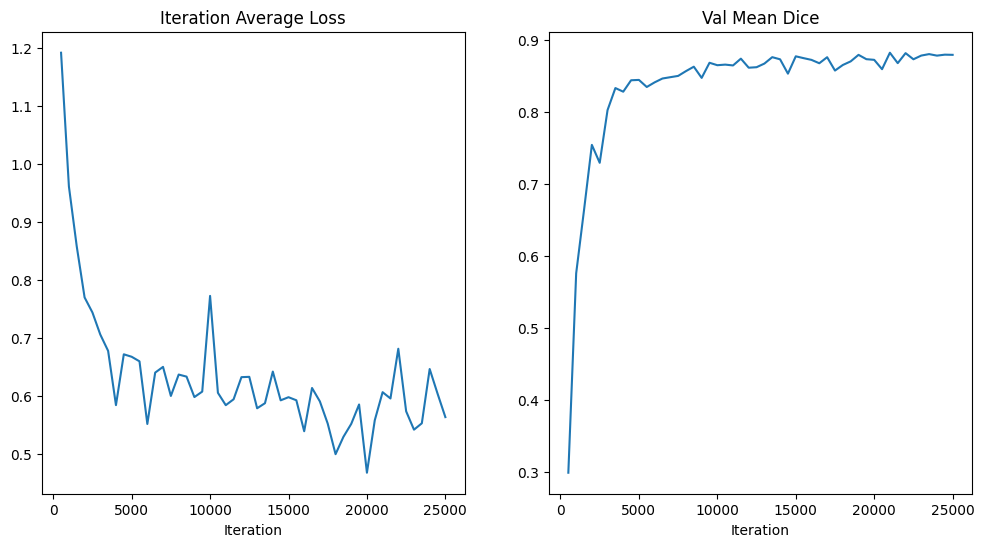

In [13]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

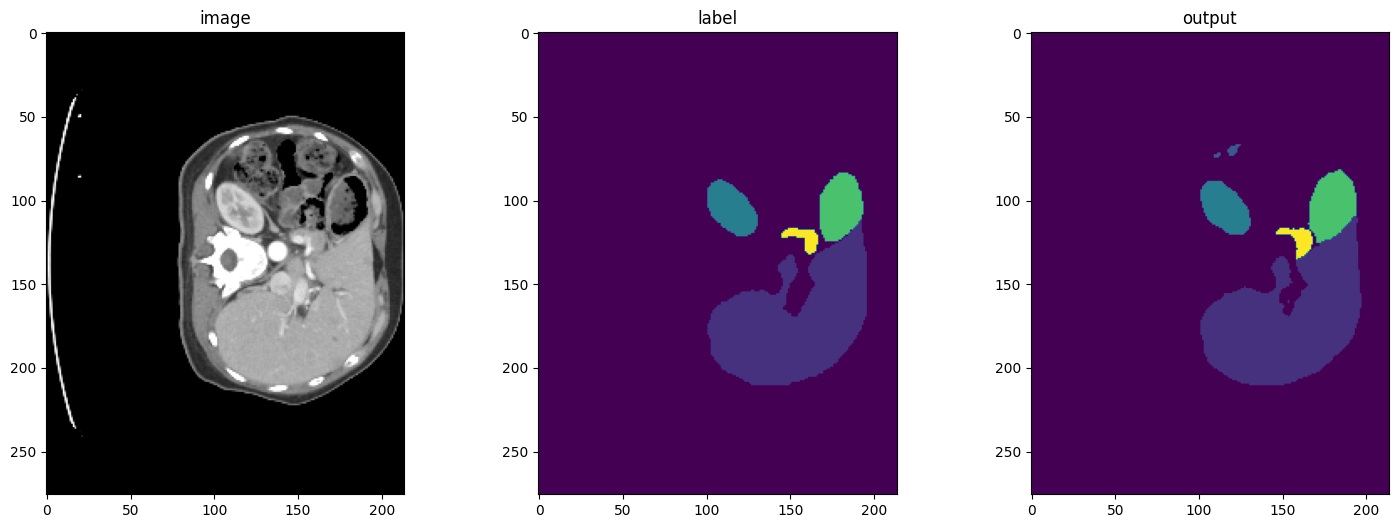

In [16]:
case_num = 1
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset1", "swinunetr_best_metric_model.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
    plt.show()